In [1]:
! python download_data.py

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

### Load Data

In [2]:
data_transforms = {
    'train': transforms.Compose([
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = 'flowers'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

### Set up GPU

In [4]:
use_gpu = torch.cuda.is_available()

### Set parameters

In [5]:
num_classes = len(class_names) # 17
batch_size = 128
momentum = 0.9
# lr, num_epoch are changing in each part.

### Train model

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## 4(a) Train from scratch

In [8]:
model = torchvision.models.resnet18(pretrained=False) # train Resnet18 from scratch
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes) # change last fc layer to num_classes=17
model = model.cuda()

In [9]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 120 epochs
# lr = 0.01     if epoch < 120
# lr = 0.001    if 120 <= epoch < 200
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=120, gamma=0.1)

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=200)

### Define plot function

In [11]:
def plot(logfile):
    with open(logfile, 'r') as f:
        line = f.readlines()
        
    train_error = []
    train_loss = []
    for i in range(len(line)):
        if 'train' in line[i]:
            line_word = line[i].split()
            train_error.append(1.0 - float(line_word[4]))
            train_loss.append(float(line_word[2]))
    
    val_error = []
    val_loss = []
    for i in range(len(line)):
        if 'val' in line[i]:
            line_word = line[i].split()
            val_error.append(1.0 - float(line_word[4]))
            val_loss.append(float(line_word[2]))
  
            
    x = np.linspace(1,len(train_error),len(train_error))
    plt.plot(x,train_error,label='training error')
    plt.plot(x,val_error,label='testing error')
    plt.xlabel('epoch')
    plt.ylabel('error')
    plt.legend()
            
    return train_error, val_error, train_loss, val_loss

### Plot of error curve of Resnet18 from scratch

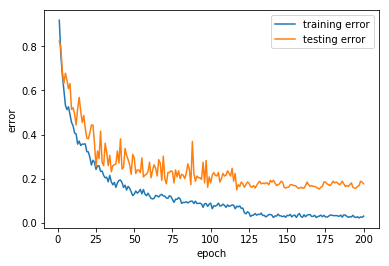

In [25]:
train_error, val_error, train_loss, val_loss = plot('log_resnet18_scratch.txt')

### Plot of loss

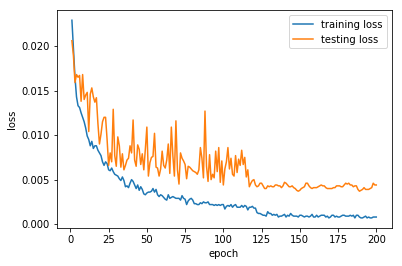

In [37]:
x = np.linspace(1,len(train_error),len(train_error))
plt.plot(x,train_loss,label='training loss')
plt.plot(x,val_loss,label='testing loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

### Final sccuracy

In [27]:
print('Final training accuracy is', 1. - train_error[-1])

Final training accuracy is 0.9701


In [28]:
print('Final test accuracy is', 1. - val_error[-1])

Final test accuracy is 0.8235


### Comment

- From the 2 plots above, we can see that after 125 epoches, the test error is not decreasing anymore while training error is still decreasing, which can be slightly overfitting. 
- ResNet18 can be a complicated network for such a small dataset, so that's why it's over-fitting.

## 4(b) Finetune Resnet18

In [34]:
model_ft = models.resnet18(pretrained=True) # use pre-trained weights
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=1) # no LR decay this time

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

### Plot of error curve

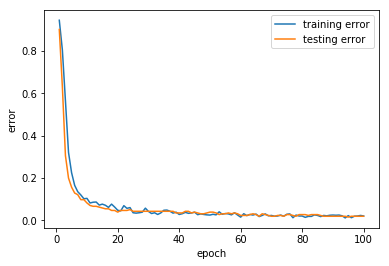

In [39]:
train_error, val_error, train_loss, val_loss = plot('log_resnet18_ft.txt')

### Plot of loss

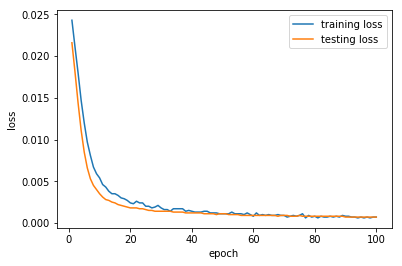

In [40]:
x = np.linspace(1,len(train_error),len(train_error))
plt.plot(x,train_loss,label='training loss')
plt.plot(x,val_loss,label='testing loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

### Final accuracy

In [41]:
print('Final training accuracy is', 1. - train_error[-1])

Final training accuracy is 0.9792


In [43]:
print('Final validation accuracy is', 1. - val_error[-1])

Final validation accuracy is 0.9804


### Comparison

#### Why use lr = 0.001?
-  Since we expect the pre-trained weights to be quite good already as compared to randomly initialized weights, we do not want to distort them too quickly and too much. A common practice for fine-tuning is to make the initial learning rate 10 times smaller than the one used for scratch training.

#### Comparison between the one trained from scratch
1. performance: Though they have similar training error, using pretrained model has much smaller validation error : final training acc: 97.92% ~= 97.01% , final val acc: 98.04% (finetune) > 82.35%. --> Finetuning's performance is much better than training from scratch.
2. training speed: 
    - training from scratch using 200 epoches takes about 26min, while finetuning using 100 epoches takes 13min. So time spent on each epoch is similar. 
    - However, the one trained from scratch, got validation accuracy around 80% after 125 epoches, which takes about 20mins, while the one using pretrained model, got validation accuracy above 90% just after 7 epoches, which might only takes 1min. --> That is much faster using pretrained model!

## 4(c) feature extraction

### (1) no convolutional layer frozen

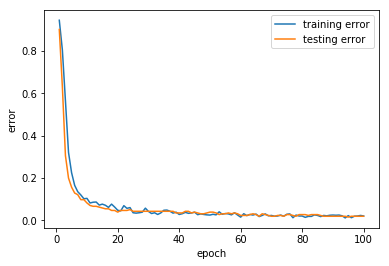

In [44]:
train_error, val_error, train_loss, val_loss = plot('log_resnet18_ft.txt')

### (2) ﬁrst 5 convolutional layers frozen

In [46]:
model_conv5 = torchvision.models.resnet18(pretrained=True)
ct = 0
for child in model_conv5.children():
    ct += 1
    if ct < 6: # freeze first 5
        for param in child.parameters():
            param.requires_grad = False

# reconstruct fc layer with requires_grad=True by default       
num_ftrs = model_conv5.fc.in_features
model_conv5.fc = nn.Linear(num_ftrs, num_classes)

### check the rest updated layer info

In [ ]:
params_to_update = []
for name,param in model_conv5.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name) # rest 12 conv layers plus 1 fc layer are to update, clear the output since too long

In [52]:
model_conv5 = model_conv5.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_conv5.parameters()), lr=0.001, momentum=0.9) # lr=0.001

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=1) # no lr decay

In [ ]:
model_conv5 = train_model(model_conv5, criterion, optimizer, exp_lr_scheduler, num_epochs=100)

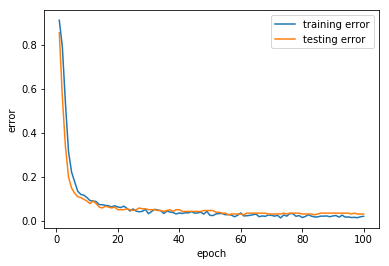

In [67]:
train_error_conv5, val_error_conv5, train_loss, val_loss = plot('log_resnet18_conv5.txt')

### (3) first 9 conv layers frozen

In [55]:
model_conv9 = torchvision.models.resnet18(pretrained=True)
ct = 0
for child in model_conv9.children():
    ct += 1
    if ct < 7: # freeze first 9
        for param in child.parameters():
            param.requires_grad = False

# reconstruct fc layer with requires_grad=True by default       
num_ftrs = model_conv9.fc.in_features
model_conv9.fc = nn.Linear(num_ftrs, num_classes)

In [ ]:
params_to_update = []
for name,param in model_conv9.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param) 
        print("\t",name) # rest 8 conv layers and 1 fc layer are to update, cleared the output since too long

In [57]:
model_conv9 = model_conv9.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_conv9.parameters()), lr=0.001, momentum=0.9) # lr=0.001

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=1) # no lr decay

In [ ]:
model_conv9 = train_model(model_conv9, criterion, optimizer, exp_lr_scheduler, num_epochs=100)

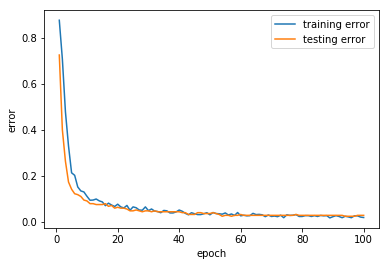

In [68]:
train_error_conv9, val_error_conv9, train_loss, val_loss = plot('log_resnet18_conv9.txt')

### (4) first 13 conv layers frozen

In [61]:
model_conv13 = torchvision.models.resnet18(pretrained=True)
ct = 0
for child in model_conv13.children():
    ct += 1
    if ct < 8: # freeze first 9
        for param in child.parameters():
            param.requires_grad = False

# reconstruct fc layer with requires_grad=True by default       
num_ftrs = model_conv13.fc.in_features
model_conv13.fc = nn.Linear(num_ftrs, num_classes)

In [62]:
params_to_update = []
for name,param in model_conv13.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param) 
        print("\t",name) # rest 4 conv layers and 1 fc layer are to update

	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [63]:
model_conv13 = model_conv13.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_conv13.parameters()), lr=0.001, momentum=0.9) # lr=0.001

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=1) # no lr decay

In [ ]:
model_conv13 = train_model(model_conv13, criterion, optimizer, exp_lr_scheduler, num_epochs=100)

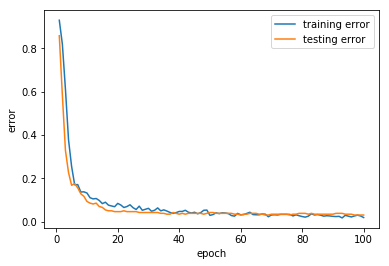

In [69]:
train_error_conv13, val_error_conv13, train_loss, val_loss = plot('log_resnet18_conv13.txt')

### (5) all 17 convolutional layers frozen

In [93]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False # set all param frozen

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)

model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9) # lr=0.001

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=100, gamma=1) # no lr decay

In [94]:
params_to_update = []
for name,param in model_conv.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param) 
        print("\t",name) # only 1 fc layer are to update

	 fc.weight
	 fc.bias


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

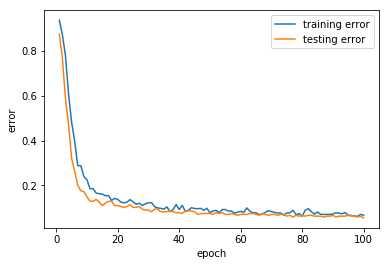

In [70]:
train_error_conv17, val_error_conv17, train_loss, val_loss = plot('log_resnet18_conv17.txt')

### Plot of best accuracy vs num of frozen layers

In [83]:
train_error_list = [min(train_error), min(train_error_conv5), min(train_error_conv9), min(train_error_conv13), min(train_error_conv17)]

In [84]:
train_acc = [1.0 - x for x in train_error_list]

In [86]:
val_error_list = [min(val_error), min(val_error_conv5), min(val_error_conv9), min(val_error_conv13), min(val_error_conv17)]

In [87]:
val_acc = [1.0 - x for x in val_error_list]

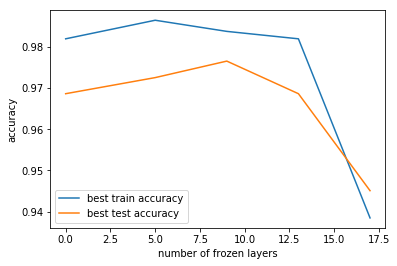

In [92]:
x = [0,5,9,13,17]
plt.plot(x,train_acc,label = 'best train accuracy')
plt.plot(x, val_acc, label = 'best test accuracy')
plt.xlabel('number of frozen layers')
plt.ylabel('accuracy')
plt.legend()

### Observed behavior

- We can see that at first, when we only frozen a few early convolution layers, the accuracy is actually increasing compared to finetuning on the whole network. This is because, usually the first few early layers of convnet extract more generic features and actually good for this specific dataset. 
- When the number of frozen layers continues to grow, i.e. freezing a large part, or even whole convolution layers make the accuracy decrease a little. This is because the later layers in convnet is more dataset-specific, since Resnet18 is trained on ImageNet, the later layers tends to learn more specific features in ImageNet. Since our dataset, the Oxford Flowers, is a little different from ImageNet, the performance of freezing whole convolution layers will not as good as former ones.
- Over all, the result is not bad: all above 95% for first 4 networks and last one around 94%, which indicates that the flower dataset is actually quite similar to ImageNet.

## 4(d) size and similarity of dataset

### (1) dataset is small and ImageNet-like

- Since the data is small, the overfitting problem might occur if we try to finetune the whole Convnet on this dataset. 
- However, since the data is similar to the ImageNet, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier and freeze all previous conv layers as feature extractor.

### (2) dataset is large and ImageNet-like

- Compared to (1), since we have more data, we won't need to worry about over-fitting. Thus, we can finetune the whole pretrained model on this large dataset.

### (3) dataset is small but not ImageNet-like

- Since the dataset is small, over-fitting might occur, so it's not recommended to finetune on pretrained model.
- Since it's not like ImageNet, according to the explanation in 4(c), we can use only a few early layers as feature extractor and extract more generic features and then finetune the rest of convolutional layers.

### (4) dataset is large but not ImageNet-like

- Since the dataset is very large, we may expect that we can afford to train a convnet model from scratch. 
- However, in practice it is very often still beneficial to initialize with weights from a pretrained model, which might increase the performance and speed up the training process as well.